<a href="https://colab.research.google.com/github/manhhung14/echocardiograms/blob/main/Project_Machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Khởi tạo thư viện**

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from collections import namedtuple
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import DataLoader


**Lấy dữ liệu**

In [10]:
!git clone https://github.com/manhhung14/echocardiograms
traindir = "/content/echocardiograms/DATA_CHAMBER_2021/train"
testdir = "/content/echocardiograms/DATA_CHAMBER_2021/test"

fatal: destination path 'echocardiograms' already exists and is not an empty directory.


**Chuẩn bị dữ liệu**

In [11]:
TrainTest = namedtuple('TrainTest', ['train', 'test'])

def get_classes():
  classes = ['2C', '3C', '4C']
  return classes

def raw_image(size):
  transform_train = transforms.Compose([
    transforms.Resize(size=(size,size)),
    transforms.ToTensor()
  ])
  transform_test = transforms.Compose([
    transforms.Resize(size=(size,size)), 
    transforms.ToTensor()
  ])
  return transform_train, transform_test

def preprocess_image(size):
  transform_train = transforms.Compose([
    transforms.Resize(size=(size,size)),
    transforms.CenterCrop(size=(size,size)),
    transforms.ToTensor(),
    transforms.Normalize((0.488, 0.478, 0.465), (0.211, 0.205, 0.199))
  ])
  transform_test = transforms.Compose([
    transforms.Resize(size=(size,size)), 
    transforms.ToTensor()
  ])
  return transform_train, transform_test

def augmentation_image(size):
  transform_train = transforms.Compose([
    transforms.Resize(size=(size,size)),
    transforms.RandomCrop(size=(size,size), padding=4,),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
  ])
  transform_test = transforms.Compose([
    transforms.Resize(size=(size,size)), 
    transforms.ToTensor()
  ])
  return transform_train, transform_test

def prepare_data(size):
  transform_train, transform_test = raw_image(size)
  # transform_train, transform_test = preprocess_image(size)
  # transform_train, transform_test = augmentation_image(size)
  trainset = torchvision.datasets.ImageFolder(root=traindir, transform=transform_train)
  testset = torchvision.datasets.ImageFolder(root=testdir, transform=transform_test)
  return TrainTest(train=trainset, test=testset)

def prepare_loader(datasets):
  trainloader = DataLoader(dataset=datasets.train, batch_size=32, shuffle=True, num_workers=4)
  testloader = DataLoader(dataset=datasets.test, batch_size=32, shuffle=False, num_workers=4)
  return TrainTest(train=trainloader, test=testloader)



**Train & Test**

In [12]:
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  model.train()
  running_loss = 0.0
  final_loss = 0.0
  reporting_steps = 40
  step = 0
  for images, labels in loader:
    step += 1
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = loss_func(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    final_loss = loss.item()
    running_loss += final_loss
    if step % reporting_steps == reporting_steps - 1:
      print(f"Epoch {epoch} step {step} ave_loss {running_loss/reporting_steps:.4f}")
      running_loss = 0.0
  return final_loss

def test_epoch(epoch, model, loader, device):
  ytrue = []
  ypred = []
  with torch.no_grad():
    model.eval()
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, dim=1)
      ytrue += list(labels.cpu().numpy())
      ypred += list(predicted.cpu().numpy())

  return ypred, ytrue


**Thực thi**

In [13]:
def main(model_in, size):
  PATH = "./" + model_in + '.pth'
  classes = get_classes()
  class_out = len(classes)

  transforms_train, transforms_test = raw_image(size)
  #transforms_train, transforms_test = preprocess_image(size)
  #transforms_train, transforms_test = augmentation_image(size)
  datasets = prepare_data(size=size)
  loaders = prepare_loader(datasets)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  print("image size: ", datasets.train[0][0].shape)
  print("device:", device)
  print("model:", model_in)

  if model_in == 'vgg16':  
    model = torchvision.models.vgg16(pretrained=False)
    model.classifier[6] = torch.nn.modules.linear.Linear(in_features=4096, out_features=class_out, bias=True)
  elif model_in == 'resnet50':
    model = torchvision.models.resnet50(pretrained=False)
    model.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=class_out, bias=True) 
  elif model_in == 'resnet18':
    model = torchvision.models.resnet18(pretrained=False)
    model.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=class_out, bias=True) 
  elif model_in == 'densenet121': 
    model = torchvision.models.densenet121(pretrained=False)
    model.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=class_out, bias=True)
  else:
    pass
    
  model.to(device)
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

  accuracies = []
  losses = []
  for epoch in range(8):
    print("---------------------------------------------------------------")
    loss = train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)
    ypred_test, ytrue_test = test_epoch(epoch, model, loaders.test, device)

    print(classification_report(ytrue_test, ypred_test, target_names=classes))
    torch.save(model.state_dict(), PATH)

    # calculate report
    ypred_test = np.array(ypred_test)
    ytrue_test = np.array(ytrue_test)
    accuracy = int((ytrue_test==ypred_test).sum() / len(ytrue_test) *100)
    accuracies.append(accuracy)
    losses.append(round(loss, 4))

    
  print("model:", model_in, ", size:", size)
  print("accr: ", accuracies)
  print("loss: ", losses)
  return model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


image size:  torch.Size([3, 224, 224])
device: cuda
model: vgg16
---------------------------------------------------------------
Epoch 0 step 39 ave_loss 1.0554
Epoch 0 step 79 ave_loss 1.1069
Epoch 0 step 119 ave_loss 0.8729
Epoch 0 step 159 ave_loss 0.5416
Epoch 0 step 199 ave_loss 0.4311
              precision    recall  f1-score   support

          2C       0.44      0.77      0.56       409
          3C       0.78      0.92      0.84       367
          4C       1.00      0.56      0.72       831

    accuracy                           0.70      1607
   macro avg       0.74      0.75      0.71      1607
weighted avg       0.81      0.70      0.71      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 step 39 ave_loss 0.2130
Epoch 1 step 79 ave_loss 0.1963
Epoch 1 step 119 ave_loss 0.1457
Epoch 1 step 159 ave_loss 0.2121
Epoch 1 step 199 ave_loss 0.0868
              precision    recall  f1-score   support

          2C       0.63      0.88      0.73       409
          3C       0.68      0.94      0.79       367
          4C       1.00      0.64      0.78       831

    accuracy                           0.77      1607
   macro avg       0.77      0.82      0.77      1607
weighted avg       0.83      0.77      0.77      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 step 39 ave_loss 0.0436
Epoch 2 step 79 ave_loss 0.0705
Epoch 2 step 119 ave_loss 0.0325
Epoch 2 step 159 ave_loss 0.0482
Epoch 2 step 199 ave_loss 0.0271
              precision    recall  f1-score   support

          2C       0.91      0.96      0.94       409
          3C       0.96      0.90      0.93       367
          4C       1.00      1.00      1.00       831

    accuracy                           0.97      1607
   macro avg       0.96      0.95      0.95      1607
weighted avg       0.97      0.97      0.97      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 step 39 ave_loss 0.0230
Epoch 3 step 79 ave_loss 0.0299
Epoch 3 step 119 ave_loss 0.0043
Epoch 3 step 159 ave_loss 0.0011
Epoch 3 step 199 ave_loss 0.0009
              precision    recall  f1-score   support

          2C       0.95      0.98      0.96       409
          3C       0.91      0.95      0.93       367
          4C       1.00      0.96      0.98       831

    accuracy                           0.96      1607
   macro avg       0.95      0.96      0.96      1607
weighted avg       0.97      0.96      0.96      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 step 39 ave_loss 0.0000
Epoch 4 step 79 ave_loss 0.0008
Epoch 4 step 119 ave_loss 0.0002
Epoch 4 step 159 ave_loss 0.0001
Epoch 4 step 199 ave_loss 0.0001
              precision    recall  f1-score   support

          2C       0.96      0.91      0.93       409
          3C       0.75      0.96      0.84       367
          4C       1.00      0.90      0.95       831

    accuracy                           0.92      1607
   macro avg       0.90      0.92      0.91      1607
weighted avg       0.93      0.92      0.92      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 step 39 ave_loss 0.0000
Epoch 5 step 79 ave_loss 0.0000
Epoch 5 step 119 ave_loss 0.0057
Epoch 5 step 159 ave_loss 0.0421
Epoch 5 step 199 ave_loss 0.0042
              precision    recall  f1-score   support

          2C       0.97      0.87      0.92       409
          3C       0.85      0.98      0.91       367
          4C       1.00      0.98      0.99       831

    accuracy                           0.95      1607
   macro avg       0.94      0.94      0.94      1607
weighted avg       0.96      0.95      0.95      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 step 39 ave_loss 0.0056
Epoch 6 step 79 ave_loss 0.0046
Epoch 6 step 119 ave_loss 0.0234
Epoch 6 step 159 ave_loss 0.0430
Epoch 6 step 199 ave_loss 0.0118
              precision    recall  f1-score   support

          2C       0.90      0.90      0.90       409
          3C       0.74      1.00      0.85       367
          4C       1.00      0.85      0.92       831

    accuracy                           0.90      1607
   macro avg       0.88      0.92      0.89      1607
weighted avg       0.92      0.90      0.90      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 step 39 ave_loss 0.0134
Epoch 7 step 79 ave_loss 0.0016
Epoch 7 step 119 ave_loss 0.0010
Epoch 7 step 159 ave_loss 0.0029
Epoch 7 step 199 ave_loss 0.0266
              precision    recall  f1-score   support

          2C       0.72      0.81      0.76       409
          3C       0.66      1.00      0.80       367
          4C       1.00      0.70      0.83       831

    accuracy                           0.80      1607
   macro avg       0.79      0.84      0.79      1607
weighted avg       0.85      0.80      0.80      1607

model: vgg16 , size: 224
accr:  [69, 76, 96, 96, 91, 95, 89, 79]
loss:  [0.0721, 0.073, 0.1405, 0.0, 0.0, 0.0004, 0.0005, 0.0008]
image size:  torch.Size([3, 64, 64])
device: cuda
model: vgg16


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


---------------------------------------------------------------
Epoch 0 step 39 ave_loss 1.0686
Epoch 0 step 79 ave_loss 1.0747
Epoch 0 step 119 ave_loss 1.0265
Epoch 0 step 159 ave_loss 0.6393
Epoch 0 step 199 ave_loss 0.4175
              precision    recall  f1-score   support

          2C       0.61      0.99      0.76       409
          3C       0.99      0.74      0.85       367
          4C       0.99      0.80      0.89       831

    accuracy                           0.84      1607
   macro avg       0.86      0.85      0.83      1607
weighted avg       0.90      0.84      0.85      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 step 39 ave_loss 0.2419
Epoch 1 step 79 ave_loss 0.1398
Epoch 1 step 119 ave_loss 0.1780
Epoch 1 step 159 ave_loss 0.1177
Epoch 1 step 199 ave_loss 0.0795
              precision    recall  f1-score   support

          2C       0.53      0.83      0.65       409
          3C       0.78      0.93      0.85       367
          4C       1.00      0.65      0.79       831

    accuracy                           0.76      1607
   macro avg       0.77      0.80      0.76      1607
weighted avg       0.83      0.76      0.77      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 step 39 ave_loss 0.0386
Epoch 2 step 79 ave_loss 0.0875
Epoch 2 step 119 ave_loss 0.0184
Epoch 2 step 159 ave_loss 0.0697
Epoch 2 step 199 ave_loss 0.0300
              precision    recall  f1-score   support

          2C       0.70      0.83      0.76       409
          3C       0.75      0.93      0.83       367
          4C       1.00      0.81      0.89       831

    accuracy                           0.84      1607
   macro avg       0.82      0.85      0.83      1607
weighted avg       0.87      0.84      0.85      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 step 39 ave_loss 0.0052
Epoch 3 step 79 ave_loss 0.0208
Epoch 3 step 119 ave_loss 0.0398
Epoch 3 step 159 ave_loss 0.0151
Epoch 3 step 199 ave_loss 0.0168
              precision    recall  f1-score   support

          2C       0.84      0.79      0.82       409
          3C       0.78      0.97      0.86       367
          4C       1.00      0.92      0.96       831

    accuracy                           0.90      1607
   macro avg       0.87      0.89      0.88      1607
weighted avg       0.91      0.90      0.90      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 step 39 ave_loss 0.0018
Epoch 4 step 79 ave_loss 0.0003
Epoch 4 step 119 ave_loss 0.0149
Epoch 4 step 159 ave_loss 0.0022
Epoch 4 step 199 ave_loss 0.0001
              precision    recall  f1-score   support

          2C       0.87      0.87      0.87       409
          3C       0.82      0.94      0.88       367
          4C       1.00      0.94      0.97       831

    accuracy                           0.92      1607
   macro avg       0.90      0.92      0.91      1607
weighted avg       0.93      0.92      0.92      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 step 39 ave_loss 0.0003
Epoch 5 step 79 ave_loss 0.0001
Epoch 5 step 119 ave_loss 0.0001
Epoch 5 step 159 ave_loss 0.0000
Epoch 5 step 199 ave_loss 0.0001
              precision    recall  f1-score   support

          2C       0.85      0.85      0.85       409
          3C       0.84      0.94      0.89       367
          4C       1.00      0.95      0.98       831

    accuracy                           0.92      1607
   macro avg       0.90      0.91      0.90      1607
weighted avg       0.93      0.92      0.92      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 step 39 ave_loss 0.0001
Epoch 6 step 79 ave_loss 0.0001
Epoch 6 step 119 ave_loss 0.0000
Epoch 6 step 159 ave_loss 0.0000
Epoch 6 step 199 ave_loss 0.0001
              precision    recall  f1-score   support

          2C       0.86      0.85      0.85       409
          3C       0.85      0.94      0.89       367
          4C       1.00      0.95      0.98       831

    accuracy                           0.93      1607
   macro avg       0.90      0.92      0.91      1607
weighted avg       0.93      0.93      0.93      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 step 39 ave_loss 0.0001
Epoch 7 step 79 ave_loss 0.0000
Epoch 7 step 119 ave_loss 0.0000
Epoch 7 step 159 ave_loss 0.0001
Epoch 7 step 199 ave_loss 0.0001
              precision    recall  f1-score   support

          2C       0.86      0.85      0.85       409
          3C       0.85      0.94      0.89       367
          4C       1.00      0.95      0.98       831

    accuracy                           0.93      1607
   macro avg       0.90      0.92      0.91      1607
weighted avg       0.93      0.93      0.93      1607

model: vgg16 , size: 64
accr:  [83, 75, 84, 89, 92, 92, 92, 92]
loss:  [0.3967, 0.0328, 0.0032, 0.0013, 0.0007, 0.0, 0.0, 0.0]
image size:  torch.Size([3, 32, 32])
device: cuda
model: vgg16


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


---------------------------------------------------------------
Epoch 0 step 39 ave_loss 1.0698
Epoch 0 step 79 ave_loss 1.0850
Epoch 0 step 119 ave_loss 0.9042
Epoch 0 step 159 ave_loss 0.6678
Epoch 0 step 199 ave_loss 0.4758
              precision    recall  f1-score   support

          2C       0.51      0.90      0.65       409
          3C       0.83      0.79      0.81       367
          4C       1.00      0.65      0.79       831

    accuracy                           0.75      1607
   macro avg       0.78      0.78      0.75      1607
weighted avg       0.84      0.75      0.76      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 step 39 ave_loss 0.2750
Epoch 1 step 79 ave_loss 0.2145
Epoch 1 step 119 ave_loss 0.1709
Epoch 1 step 159 ave_loss 0.1934
Epoch 1 step 199 ave_loss 0.1678
              precision    recall  f1-score   support

          2C       0.53      0.72      0.61       409
          3C       0.60      0.93      0.73       367
          4C       1.00      0.57      0.73       831

    accuracy                           0.69      1607
   macro avg       0.71      0.74      0.69      1607
weighted avg       0.79      0.69      0.70      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 step 39 ave_loss 0.1321
Epoch 2 step 79 ave_loss 0.0836
Epoch 2 step 119 ave_loss 0.0484
Epoch 2 step 159 ave_loss 0.0463
Epoch 2 step 199 ave_loss 0.0127
              precision    recall  f1-score   support

          2C       0.67      0.83      0.74       409
          3C       0.64      0.88      0.74       367
          4C       0.99      0.72      0.83       831

    accuracy                           0.78      1607
   macro avg       0.77      0.81      0.77      1607
weighted avg       0.83      0.78      0.79      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 step 39 ave_loss 0.0022
Epoch 3 step 79 ave_loss 0.0499
Epoch 3 step 119 ave_loss 0.0489
Epoch 3 step 159 ave_loss 0.0502
Epoch 3 step 199 ave_loss 0.0251
              precision    recall  f1-score   support

          2C       0.81      0.87      0.84       409
          3C       0.63      0.94      0.76       367
          4C       1.00      0.75      0.86       831

    accuracy                           0.82      1607
   macro avg       0.82      0.85      0.82      1607
weighted avg       0.87      0.82      0.83      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 step 39 ave_loss 0.0112
Epoch 4 step 79 ave_loss 0.0016
Epoch 4 step 119 ave_loss 0.0061
Epoch 4 step 159 ave_loss 0.0011
Epoch 4 step 199 ave_loss 0.0160
              precision    recall  f1-score   support

          2C       0.76      0.80      0.78       409
          3C       0.60      0.94      0.74       367
          4C       1.00      0.73      0.84       831

    accuracy                           0.80      1607
   macro avg       0.79      0.82      0.79      1607
weighted avg       0.85      0.80      0.80      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 step 39 ave_loss 0.0298
Epoch 5 step 79 ave_loss 0.0095
Epoch 5 step 119 ave_loss 0.0007
Epoch 5 step 159 ave_loss 0.0001
Epoch 5 step 199 ave_loss 0.0000
              precision    recall  f1-score   support

          2C       0.70      0.94      0.80       409
          3C       0.78      0.92      0.84       367
          4C       1.00      0.75      0.86       831

    accuracy                           0.84      1607
   macro avg       0.83      0.87      0.83      1607
weighted avg       0.87      0.84      0.84      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 step 39 ave_loss 0.0000
Epoch 6 step 79 ave_loss 0.0000
Epoch 6 step 119 ave_loss 0.0000
Epoch 6 step 159 ave_loss 0.0001
Epoch 6 step 199 ave_loss 0.0001
              precision    recall  f1-score   support

          2C       0.71      0.93      0.80       409
          3C       0.76      0.92      0.83       367
          4C       1.00      0.75      0.86       831

    accuracy                           0.84      1607
   macro avg       0.82      0.87      0.83      1607
weighted avg       0.87      0.84      0.84      1607

---------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 step 39 ave_loss 0.0001
Epoch 7 step 79 ave_loss 0.0001
Epoch 7 step 119 ave_loss 0.0000
Epoch 7 step 159 ave_loss 0.0001
Epoch 7 step 199 ave_loss 0.0001
              precision    recall  f1-score   support

          2C       0.71      0.93      0.81       409
          3C       0.76      0.93      0.84       367
          4C       1.00      0.76      0.86       831

    accuracy                           0.84      1607
   macro avg       0.82      0.87      0.83      1607
weighted avg       0.87      0.84      0.84      1607

model: vgg16 , size: 32
accr:  [74, 69, 78, 82, 79, 83, 83, 83]
loss:  [0.2371, 0.0719, 0.005, 0.0117, 0.0015, 0.0, 0.0, 0.0001]


AttributeError: ignored

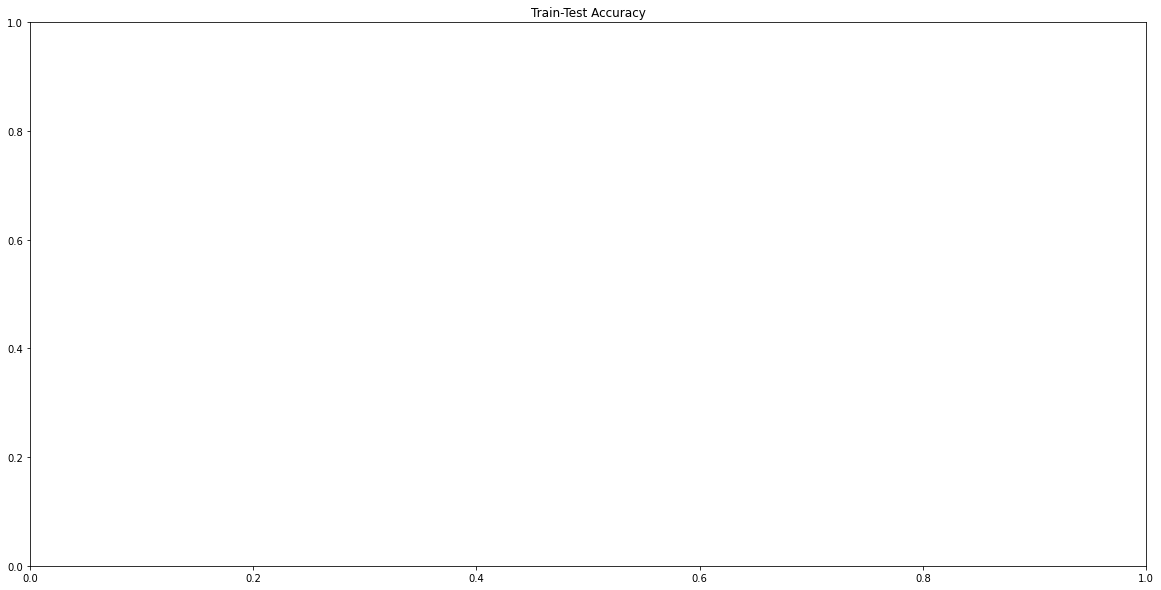

In [14]:
model1 = main('vgg16', 224)
model2 = main('vgg16', 64)
model3 = main('vgg16', 32)

